In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import numpy as np


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import numpy as np

class MaskedMNIST(Dataset):
    def __init__(self, root, train=True, num_masks=10, mask_size=7):
        self.dataset = datasets.MNIST(root=root, train=train, download=True, transform=transforms.ToTensor())
        self.num_masks = num_masks
        self.mask_size = mask_size

    def apply_masks(self, img):
        img = img.clone()  # 원본 이미지의 복사본 생성
        _, h, w = img.size()

        for _ in range(self.num_masks):
            # 마스크 위치 랜덤 생성
            mask_x = np.random.randint(0, w - self.mask_size)
            mask_y = np.random.randint(0, h - self.mask_size)
            
            # 마스크 생성 (여기서는 단순히 0으로 채우기)
            img[:, mask_y:mask_y + self.mask_size, mask_x:mask_x + self.mask_size] = 0
        
        return img

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        masked_img = self.apply_masks(img)
        return masked_img, img, target


In [3]:
from torch.utils.data import DataLoader

batch_size = 128
data_dir = './data2'
num_masks = 7
mask_size = 10

train_dataset = MaskedMNIST(root=data_dir, train=True, num_masks=num_masks, mask_size=mask_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
    
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:
def loss_function(recon_x, masked_img, original_img, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, original_img.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [6]:
import torch.optim as optim

# 모델, 옵티마이저 및 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 학습 루프
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for masked_imgs, original_imgs, _ in train_loader:
        masked_imgs, original_imgs = masked_imgs.to(device), original_imgs.to(device)

        optimizer.zero_grad()

        # 모델의 출력과 손실 계산
        recon_batch, mu, logvar = model(masked_imgs)
        loss = loss_function(recon_batch, masked_imgs, original_imgs, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * masked_imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [1/100], Loss: 26285.8604
Epoch [2/100], Loss: 23170.6471
Epoch [3/100], Loss: 22593.3984
Epoch [4/100], Loss: 22272.4671
Epoch [5/100], Loss: 22073.2840
Epoch [6/100], Loss: 21934.5289
Epoch [7/100], Loss: 21860.4627
Epoch [8/100], Loss: 21800.3390
Epoch [9/100], Loss: 21716.5952
Epoch [10/100], Loss: 21655.7665
Epoch [11/100], Loss: 21577.3837
Epoch [12/100], Loss: 21529.9498
Epoch [13/100], Loss: 21501.8411
Epoch [14/100], Loss: 21453.0176
Epoch [15/100], Loss: 21400.9436
Epoch [16/100], Loss: 21341.5655
Epoch [17/100], Loss: 21331.0115
Epoch [18/100], Loss: 21294.4036
Epoch [19/100], Loss: 21277.0238
Epoch [20/100], Loss: 21236.9561
Epoch [21/100], Loss: 21210.6004
Epoch [22/100], Loss: 21213.3948
Epoch [23/100], Loss: 21208.8287
Epoch [24/100], Loss: 21172.7297
Epoch [25/100], Loss: 21129.4650
Epoch [26/100], Loss: 21072.3390
Epoch [27/100], Loss: 21090.5241
Epoch [28/100], Loss: 21063.5165
Epoch [29/100], Loss: 21072.5562
Epoch [30/100], Loss: 21050.5321
Epoch [31/100], Los

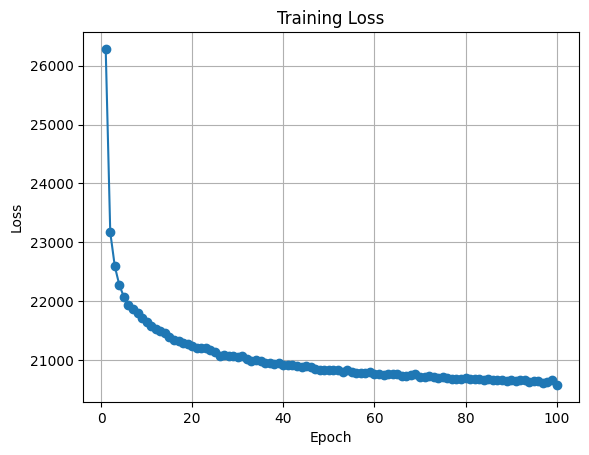

In [7]:
# 손실 값 저장
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()


In [21]:
import torch
import torch.nn as nn

class abReLU(nn.Module):
    def __init__(self, init_a=0.6, init_b=0.0):
        super(abReLU, self).__init__()

        self.a = nn.Parameter(torch.tensor(init_a, dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor(init_b, dtype=torch.float32))

    def forward(self, x):
        return torch.where(x >= self.b, self.a * (x - self.b), torch.zeros_like(x))


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE2(nn.Module):
    def __init__(self, init_a=7.0, init_b=0.0):
        super(VAE2, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.custom_relu = abReLU(init_a, init_b)
    
    def encode(self, x):
        h1 = self.custom_relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = self.custom_relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [23]:
import torch.optim as optim

# 모델, 옵티마이저 및 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = VAE2().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 학습 루프
num_epochs = 100
losses2 = []

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    for masked_imgs, original_imgs, _ in train_loader:
        masked_imgs, original_imgs = masked_imgs.to(device), original_imgs.to(device)

        optimizer.zero_grad()

        # 모델의 출력과 손실 계산
        recon_batch, mu, logvar = model2(masked_imgs)
        loss2 = loss_function(recon_batch, masked_imgs, original_imgs, mu, logvar)
        loss2.backward()
        optimizer.step()

        running_loss += loss2.item() * masked_imgs.size(0)

    epoch_loss2 = running_loss / len(train_loader.dataset)
    losses2.append(epoch_loss2)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss2:.4f}')


Epoch [1/100], Loss: 98945.0654
Epoch [2/100], Loss: 99031.3508
Epoch [3/100], Loss: 99024.0573
Epoch [4/100], Loss: 98981.2038
Epoch [5/100], Loss: 98943.9475
Epoch [6/100], Loss: 98955.7994
Epoch [7/100], Loss: 98918.1360
Epoch [8/100], Loss: 98994.2938
Epoch [9/100], Loss: 98875.9752
Epoch [10/100], Loss: 98919.1943
Epoch [11/100], Loss: 98952.8035
Epoch [12/100], Loss: 98989.7239
Epoch [13/100], Loss: 98917.1329
Epoch [14/100], Loss: 98938.0469
Epoch [15/100], Loss: 98991.8558
Epoch [16/100], Loss: 98969.8409
Epoch [17/100], Loss: 98937.7734
Epoch [18/100], Loss: 98973.0339
Epoch [19/100], Loss: 98920.6899
Epoch [20/100], Loss: 98894.2521
Epoch [21/100], Loss: 98945.6901
Epoch [22/100], Loss: 98966.2106
Epoch [23/100], Loss: 98928.0940
Epoch [24/100], Loss: 98944.2714
Epoch [25/100], Loss: 98975.6528
Epoch [26/100], Loss: 98979.9189
Epoch [27/100], Loss: 98914.5525
Epoch [28/100], Loss: 99012.1914
Epoch [29/100], Loss: 98954.8546
Epoch [30/100], Loss: 98988.7206
Epoch [31/100], Los

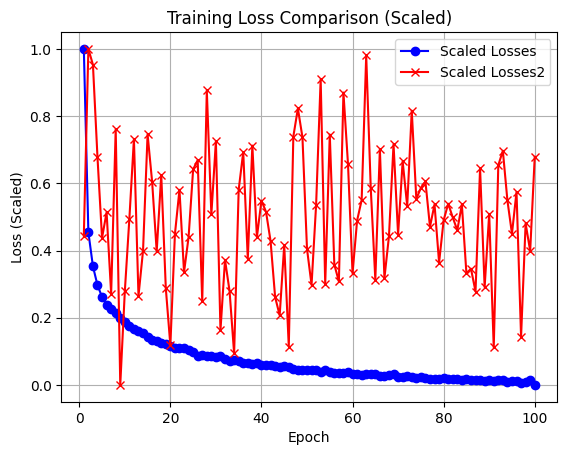

In [24]:
# Min-max scaling function
def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

scaled_losses = min_max_scale(np.array(losses))
scaled_losses2 = min_max_scale(np.array(losses2))

plt.plot(range(1, num_epochs + 1), scaled_losses, marker='o', label='Scaled Losses', color='blue')  
plt.plot(range(1, num_epochs + 1), scaled_losses2, marker='x', label='Scaled Losses2', color='red') 

plt.xlabel('Epoch')
plt.ylabel('Loss (Scaled)')
plt.title('Training Loss Comparison (Scaled)')

plt.legend()

plt.grid(True)

plt.show()